In [285]:
import os
import tqdm
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

In [286]:
def encode_seq(seq):
    encoding_list = []
    for i in range(len(seq)):
        if seq[i] == "*":
            encoding_list.append(np.zeros(5).reshape(1,5))
        elif seq[i] == "_":
            # print("Error: seqCDR contains '_'")
            # encoding_list.append(np.zeros(5).reshape(1,5))
            return np.nan
        else:
            encoding_list.append(af.loc[seq[i]].values.reshape(1,5))
    return np.array(encoding_list).reshape(1,-1)

af = pd.read_csv("~/data/project/pMHC-TCR/library/Atchley_factors.csv")
af.index = af["Amino acid"]
af.drop(columns=["Amino acid"], inplace=True)

In [287]:
class TCREncodeData(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path, index_col=0)
        # just use the positive samples
        df = df[df["Class"] == "positive"]
        df = df.drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")

        df = df.loc[df["AseqCDR3"].str.len() < 40, :]
        df = df.loc[df["BseqCDR3"].str.len() < 40, :]

        len_map = {
            "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
            "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
        }
        print(len_map)
        
        for chain in ["AseqCDR3", "BseqCDR3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(
                lambda x: x + "*" * (length - len(x))
            )
            df[chain] = df[chain].apply(lambda x: encode_seq(x))

        df = df.dropna()
        print(df.shape)

        X = torch.zeros((len(df), 0))
        for seq in ["AseqCDR3", "BseqCDR3"]:
            X = torch.cat((X, torch.from_numpy(
                np.vstack(df[seq].values)
            )), dim=1)
        
        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0).values

        self.X = X
        self.y = torch.from_numpy(y).float()
        self.Aseq_len = len_map["AseqCDR3"]
        self.Bseq_len = len_map["BseqCDR3"]

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [288]:
file_path = "~/data/project/data/seqData/20230228.csv"
TCRData = TCREncodeData(file_path)

{'AseqCDR3': 25, 'BseqCDR3': 21}
(787, 5)


# TCR autoencoder discrete

In [289]:
class TCR_a_autoencoder(nn.Module):
    def __init__(self, kernel_size=3, stride=2, padding=1, batch_size=16):
        super(TCR_a_autoencoder, self).__init__()
        self.batch_size = batch_size
        self.encoder = nn.Sequential(
            # (W + 2P - K)/S + 1
            # (batch_size, 5, 25)
            nn.Conv1d(5, 7, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 7, 13)
            nn.LeakyReLU(),
            
            nn.Conv1d(7, 8, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 8, 7)
            nn.LeakyReLU(),

            nn.Conv1d(8, 9, kernel_size=5, stride=stride, padding=padding),
            # (batch_size, 9, 3)
            nn.LeakyReLU(),

            nn.Conv1d(9, 10, kernel_size=5, stride=stride, padding=padding),
            nn.LeakyReLU(),
            # (batch_size, 10, 1)
        )

        self.decoder = nn.Sequential(
            # (w-1)S-2P+F
            # (batch_size, 10, 1)
            nn.ConvTranspose1d(10, 9, kernel_size=3, stride=2, padding=0),
            # (batch_size, 9, 3)
            nn.LeakyReLU(),
            
            nn.ConvTranspose1d(9, 8, kernel_size=3, stride=2, padding=0),
            # (batch_size, 8, 7)
            nn.LeakyReLU(),

            nn.ConvTranspose1d(8, 7, kernel_size=3, stride=2, padding=1),
            # (batch_size, 7, 13)
            nn.LeakyReLU(),

            nn.ConvTranspose1d(7, 5, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            # (batch_size, 5, 25)
        )
    
    def forward(self, input):
        x = input.float()
        encoded = self.encoder(x)
        encoded = encoded.float()
        output = self.decoder(encoded)
        return encoded, output

In [290]:
class TCR_b_autoencoder(nn.Module):
    def __init__(self, kernel_size=3, stride=2, padding=1, batch_size=16):
        super(TCR_b_autoencoder, self).__init__()
        self.batch_size = batch_size
        self.encoder = nn.Sequential(
            # (W + 2P - K)/S + 1
            # (batch_size, 5, 21)
            nn.Conv1d(5, 7, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 7, 11)
            nn.LeakyReLU(),

            nn.Conv1d(7, 8, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 8, 6)
            nn.LeakyReLU(),

            nn.Conv1d(8, 9, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 9, 3)
            nn.LeakyReLU(),

            nn.Conv1d(9, 10, kernel_size=5, stride=stride, padding=padding),
            # (batch_size, 10, 1)
            # nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            # (W-1)S-2P+F
            # (batch_size, 10, 1)
            nn.ConvTranspose1d(10, 9, kernel_size=3, stride=stride, padding=0),
            # (batch_size, 9, 3)
            nn.LeakyReLU(),

            nn.ConvTranspose1d(9, 8, kernel_size=3, stride=stride, padding=padding),
            # (batch_size, 8, 5)
            nn.LeakyReLU(),

            nn.ConvTranspose1d(8, 7, kernel_size=3, stride=stride, padding=0),
            # (batch_size, 7, 11)
            nn.LeakyReLU(),

            nn.ConvTranspose1d(7, 5, kernel_size=3, stride=stride, padding=padding),
            # (batch_size, 5, 21)
            nn.LeakyReLU(),
        )

    def forward(self, input):
        x= input.float()
        encoded = self.encoder(x)
        encoded = encoded.float()
        output = self.decoder(encoded)
        return encoded, output

In [291]:
class Discrete_ae(nn.Module):
    # this module contains the two parts of ae which could embedding the 
    def __init__(self, kernel_size=3, stride=2, padding=1, batch_size=16, seq_len_a=None, seq_len_b=None):
        super(Discrete_ae, self).__init__()
        self.ae_a = TCR_a_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)
        self.ae_b = TCR_b_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)
        self.seq_len_a = seq_len_a
        self.seq_len_b = seq_len_b
        self.batch_size = batch_size
    
    def forward(self, input):
        # input shape (batch_size, 5, 25 + 21)
        # split the input into two parts
        input_a = input[:, :, :self.seq_len_a]
        input_b = input[:, :, self.seq_len_a:]
        # print("input shape:",input_a.shape, input_b.shape)
        # encode the two parts
        encoded_a, output_a = self.ae_a(input_a)
        encoded_b, output_b = self.ae_b(input_b)
        # print("output shape", output_a.shape, output_b.shape)
        # the shape of encoded_a and encoded_b is (batch_size, 10, 1)
        # concatenate the two parts
        encoded = torch.cat((encoded_a, encoded_b), dim=1)
        output = torch.cat((output_a, output_b), dim=2)
        # the shape of encoded is (batch_size, 20, 1)
        # the shape of output is (batch_size, 5, 25 + 21)
        return encoded, output

Train Epoch: 1 [0/629 (0%)]	Loss: 1.305213
Train Epoch: 2 [0/629 (0%)]	Loss: 1.219676
Train Epoch: 3 [0/629 (0%)]	Loss: 1.346990
Train Epoch: 4 [0/629 (0%)]	Loss: 1.253119
Train Epoch: 5 [0/629 (0%)]	Loss: 1.271558
Train Epoch: 6 [0/629 (0%)]	Loss: 1.218647
Train Epoch: 7 [0/629 (0%)]	Loss: 1.264087
Train Epoch: 8 [0/629 (0%)]	Loss: 1.225438
Train Epoch: 9 [0/629 (0%)]	Loss: 1.166008
Train Epoch: 10 [0/629 (0%)]	Loss: 1.182154
Train Epoch: 11 [0/629 (0%)]	Loss: 1.097659
Train Epoch: 12 [0/629 (0%)]	Loss: 1.200780
Train Epoch: 13 [0/629 (0%)]	Loss: 1.197685
Train Epoch: 14 [0/629 (0%)]	Loss: 1.184732
Train Epoch: 15 [0/629 (0%)]	Loss: 1.173167
Train Epoch: 16 [0/629 (0%)]	Loss: 1.162787
Train Epoch: 17 [0/629 (0%)]	Loss: 1.234800
Train Epoch: 18 [0/629 (0%)]	Loss: 1.264815
Train Epoch: 19 [0/629 (0%)]	Loss: 1.141494
Train Epoch: 20 [0/629 (0%)]	Loss: 1.093458
Train Epoch: 21 [0/629 (0%)]	Loss: 1.187987
Train Epoch: 22 [0/629 (0%)]	Loss: 1.017957
Train Epoch: 23 [0/629 (0%)]	Loss: 1.0711

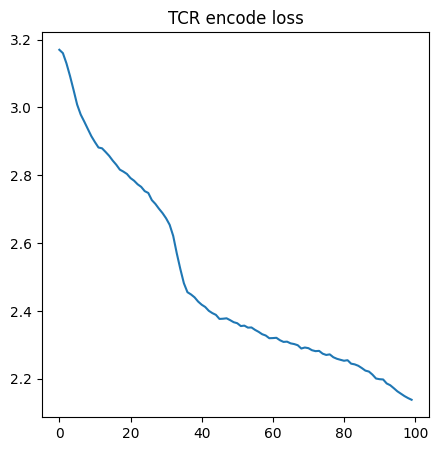

In [292]:
def train_ae(model, train_loader, optimizer, criterion, epoch, seq_len):
    model.train()
    batch_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.float()
        data = data.view(batch_size, 5, seq_len)
        optimizer.zero_grad()
        _, output = model(data)
        # print(output.shape, data.shape)
        loss = criterion(output, data)
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        
    return batch_loss / len(data)

epochs = 100
batch_size = 16
learning_rate = 1e-3
kernel_size = 3
stride = 2
padding = 1
seq_len_a = TCRData.Aseq_len
seq_len_b = TCRData.Bseq_len

# train the autoencoder
model = Discrete_ae(kernel_size=kernel_size, stride=stride, 
            padding=padding, batch_size=batch_size, 
            seq_len_a=seq_len_a, seq_len_b=seq_len_b)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_data, test_data = torch.utils.data.random_split(TCRData, 
                         lengths=[int(np.floor(len(TCRData)*0.8)), int(np.ceil(len(TCRData)*0.2))])
train_data = Subset(TCRData, train_data.indices)
test_data = Subset(TCRData, test_data.indices)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

# plot the loss 
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# plot the loss
TCR_encode_losses = []
TCR_accuracy = 0
for epoch in range(1, epochs + 1):
    TCR_encode_loss = train_ae(model, train_loader, optimizer, criterion, epoch, seq_len_a+seq_len_b)
    TCR_encode_losses.append(TCR_encode_loss)
ax.set_title("TCR encode loss")
ax.plot(TCR_encode_losses, label="TCR encode loss")

In [293]:
# test
# int(np.floor(len(TCRData)*0.8)) + int(np.ceil(len(TCRData)*0.2))
a = train_data[0][0]
a = a.view(1, 5, 25+21)
split_a = a[:, :, :25]
split_b = a[:, :, 25:]
print(split_a.shape, split_b.shape)
layer = nn.ConvTranspose1d(1 , 1, kernel_size=3, stride=stride, padding=1)
input = torch.randn(16, 1, 13)
output = layer(input)
print(output.shape)

torch.Size([1, 5, 25]) torch.Size([1, 5, 21])
torch.Size([16, 1, 25])


In [294]:
# test the Discrete_ae
epochs = 100
batch_size = 16
learning_rate = 1e-3
kernel_size = 3
stride = 2
padding = 1

model.eval()

TCR_encode = torch.zeros((0, 20, 1))
for i in range(len(TCRData)):
    TCR_seq = TCRData[i][0]
    encode_shape = int(TCR_seq.shape[0] / 5)
    TCR_seq = TCR_seq.view(1, 5, encode_shape).float()
    encode, _ = model(TCR_seq)
    TCR_encode = torch.cat((TCR_encode, encode), dim=0)

In [295]:
TCR_encode.shape

torch.Size([787, 20, 1])

In [296]:
class pMHC_TCRDataset(Dataset):
    def __init__(self, file_path,
               only_positive: bool =True,
               encoding_model: nn.Module = None,
               encoding_size: int = 20) -> None:
        df, HLA_encoded, y = self.basic_io(file_path, only_positive)
        X_TCR_seq = torch.zeros((len(df), 0))
        for region in ["AseqCDR3", "BseqCDR3"]:
            TCR_seq = df[region].values
            TCR_seq_encode = torch.zeros((0, TCR_seq[0].shape[1]))
            for i in range(len(TCR_seq)):
                encoding = torch.from_numpy(TCR_seq[i][0])
                encoding = encoding.reshape(1, -1)
                TCR_seq_encode = torch.cat((TCR_seq_encode, encoding), dim=0)
            X_TCR_seq = torch.cat((X_TCR_seq, TCR_seq_encode), dim=1)
        TCR_encoded = self.TCR_encoding(X_TCR_seq, encoding_model, encoding_size)
        Neo_encoded = self.Neo_encoding(df)

        data_pos = np.concatenate((TCR_encoded, Neo_encoded, HLA_encoded), axis=1)
        data_neg = self.generate_neg_sample(TCR_encoded, Neo_encoded, HLA_encoded)
        self.data = np.concatenate((data_pos, data_neg), axis=0)
        self.label = np.concatenate((y, np.zeros(len(data_neg))), axis=0)

    def basic_io(self, file_path, only_positive=True):
        df = pd.read_csv(file_path, index_col=0)
        if only_positive:
            df = df[df["Class"] == "positive"]
        df = df.drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")
        df = df.loc[df["AseqCDR3"].str.len() < 40, :]
        df = df.loc[df["BseqCDR3"].str.len() < 40, :]

        len_map = {
            "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
            "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
        }
        print(len_map)
        self.len_map = len_map
        
        for chain in ["AseqCDR3", "BseqCDR3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(
                lambda x: x + "*" * (length - len(x))
            )
            df[chain] = df[chain].apply(lambda x: encode_seq(x))

        df = df.dropna()

        X_HLA = df["HLA"].values.reshape(-1, 1)
        HLAencoder = OneHotEncoder()
        X_HLA_encoded = HLAencoder.fit_transform(X_HLA).toarray()
        
        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0)
        y.value_counts().plot.pie(autopct='%.2f')
        return df, X_HLA_encoded, y.values

    def TCR_encoding(self, TCR_seq, encoding_model, encoding_size):
        seq_len_a = self.len_map["AseqCDR3"]
        seq_len_b = self.len_map["BseqCDR3"]
        TCR_seq = TCR_seq.view(-1, 5, seq_len_a+seq_len_b).float()
        print(TCR_seq.shape)
        encode, _ = encoding_model(TCR_seq)
        encode = encode.view(-1, encoding_size)
        return encode.cpu().detach().numpy()

    def Neo_encoding(self, df):
        df["Neo_first3"] = df["NeoAA"].str[:3]
        df["Neo_last3"] = df["NeoAA"].str[-3:]
        df = df.drop(columns=["NeoAA"])

        # encode the Neo_first3, Neo_last3
        for seq in ["Neo_first3", "Neo_last3"]:
            df[seq] = df[seq].apply(lambda x: encode_seq(x))
        df = df.dropna()

        Neo_enocoded = torch.zeros((len(df), 0))
        for seq in ["Neo_first3", "Neo_last3"]:
            neo_seq = df.loc[:, seq].values
            seq_encode = torch.zeros((0, neo_seq[0].shape[1]))
            for i in range(len(neo_seq)):
                encoding = torch.from_numpy(neo_seq[i][0])
                encoding = encoding.reshape(1, -1)
                seq_encode = torch.cat((seq_encode, encoding), dim=0)
            Neo_enocoded = torch.cat((Neo_enocoded, seq_encode), dim=1)
        return Neo_enocoded
    
    def generate_neg_sample(self, TCR_encoded, Neo_encoded, HLA_encoded):
        # this function is used to generate negative sample
        # which is the random shuffle of the elements and features of the positive sample
        # the number of negative sample is the same as the positive sample

        # shuffle the TCR_encoded and Neo_encoded and HLA_encoded
        # Get the unique feature pool for each of the feature
        TCR_encoded_pool = torch.from_numpy(np.unique(TCR_encoded, axis=0))
        Neo_encoded_pool = torch.from_numpy(np.unique(Neo_encoded, axis=0))
        HLA_encoded_pool = torch.from_numpy(np.unique(HLA_encoded, axis=0))
        data_neg = torch.zeros((0, TCR_encoded.shape[1] + Neo_encoded.shape[1] + HLA_encoded.shape[1]))
        for i in range(len(TCR_encoded)):
            TCR_choice = random.choice(TCR_encoded_pool)
            Neo_choice = random.choice(Neo_encoded_pool)
            HLA_choice = random.choice(HLA_encoded_pool)
            data_neg = torch.cat((data_neg, torch.cat((TCR_choice, Neo_choice, HLA_choice), dim=0).reshape(1, -1)), dim=0)
        return data_neg
    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

{'AseqCDR3': 25, 'BseqCDR3': 21}
torch.Size([787, 5, 46])


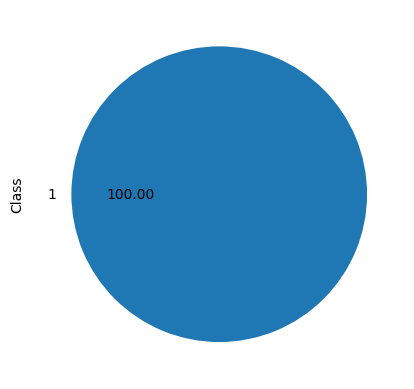

In [297]:
pMHC_TCRData = pMHC_TCRDataset(file_path, only_positive=True, encoding_model=model, encoding_size=20)

In [298]:
# torch.randperm(10)
# find unique element of a tensor
# torch.unique(torch.tensor([[0, 1, 2], [0, 1, 2], [1,2,3]]), dim=0)
# set(torch.tensor([0, 1, 2, 1, 3]))
# set(torch.tensor([0, 1, 2, 3, 4, 3]))
# torch.tensor([0, 1, 2, 3, 4, 5]).view(-1, 2, 3)
# seq_len_a + seq_len_b
# df = pd.read_csv(file_path, index_col=0)
# df = df[df["Class"] == "positive"]
# df = df.drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")
# df = df.loc[df["AseqCDR3"].str.len() < 40, :]
# df = df.loc[df["BseqCDR3"].str.len() < 40, :]

# len_map = {
#     "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
#     "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
# }
# print(len_map)
# # self.len_map = len_map
# model

np.unique(np.array([[0, 1, 2], [0, 1, 2], [1,2,3]]), axis=0)

array([[0, 1, 2],
       [1, 2, 3]])

Prediction model

In [299]:
class prediction_model(nn.Module):
    def __init__(self,
                 input_size,
                 batch_size=32) -> None:
        super(prediction_model, self).__init__()
        self.input_size = input_size
        self.batch_size = batch_size
        self.linear_layer = nn.Sequential(
            nn.Linear(self.input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        input = input.view(self.batch_size, self.input_size)
        output = self.linear_layer(input)
        output = self.softmax(output)
        return output

In [300]:
def train(fold, model, device, train_loader, optiimzer, epoch, criterion):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(torch.bool).view(-1, 1)
        one_hot_target = torch.zeros((target.shape[0], 2))
        one_hot_target[(target==1).squeeze(), 1] = 1
        one_hot_target[(target==0).squeeze(), 0] = 1
        
        data, one_hot_target = data.to(device), one_hot_target.to(device)
        data = data.view(-1, data.shape[1]).to(torch.float32)
        output = model(data)
        loss = criterion(output, one_hot_target)
        train_loss += loss.item() / (len(train_loader) * data.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(one_hot_target.argmax(dim=1, keepdim=True)).sum().item()

        if batch_idx % 100 == 0:
            print(f"Training stage for Flod {fold} Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader) * data.size(0)} \
                ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
            
    return train_loss, correct / (len(train_loader) * data.size(0))
    
def val(fold, model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    pred_history = []
    target_history = []

    with torch.no_grad():
        for data, target in val_loader:
            target = target.to(torch.bool).view(-1, 1)
            one_hot_target = torch.zeros((target.shape[0], 2))
            one_hot_target[(target==1).squeeze(), 1] = 1
            one_hot_target[(target==0).squeeze(), 0] = 1

            data, one_hot_target = data.to(device), one_hot_target.to(device)
            data = data.view(-1, data.shape[1]).to(torch.float32)
            output = model(data)
            val_loss += nn.CrossEntropyLoss()(output, one_hot_target.data).item() / (len(val_loader) * data.size(0))
            pred = output.argmax(dim=1, keepdim=True)
            target = one_hot_target.argmax(dim=1, keepdim=True)
            correct += pred.eq(target).sum().item()
            pred_history.extend(output.cpu().detach().numpy())
            target_history.extend(one_hot_target.cpu().detach().numpy())
        
        print(f"val set for fold{fold}: Average Loss: \
          {val_loss:.4f}, Accuracy: {correct}/{(len(val_loader) * data.size(0))} \
          ({100. * correct / (len(val_loader) * data.size(0)):.0f}%)")
        auc = roc_auc_score(target_history, pred_history)
        print(f"val set for fold{fold}: AUC: {auc:.4f}")
    return val_loss, correct / (len(val_loader) * data.size(0)), pred_history, target_history

In [301]:
class CustomSubset(Subset):
    '''
    A custom subset class that keep the data and targets
    '''
    def __init__(self, dataset, indices):
        super().__init__(dataset, indices)
        self.data = dataset.data
        self.label = dataset.label

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        return x, y
    
    def __len__(self):
        return len(self.indices)

In [302]:
batch_size = 32
input_size = 20 + 6 * 5 + 2
folds = 5
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

best_vloss = 1e6

def reset_weights(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

model = prediction_model(input_size, batch_size).to(device)
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

training_dataset, testing_dataset = torch.utils.data.random_split(pMHC_TCRData, [int(len(pMHC_TCRData)*0.8), len(pMHC_TCRData)-int(len(pMHC_TCRData)*0.8)])
training_dataset = CustomSubset(pMHC_TCRData, training_dataset.indices)
testing_dataset = CustomSubset(pMHC_TCRData, testing_dataset.indices)

Using device: cpu


-------------------Fold 0-------------------
Training stage for Flod 0 Epoch: 1 [0/992                 (0%)]	Loss: 0.689544
val set for fold0: Average Loss:           0.0213, Accuracy: 124/224           (55%)
val set for fold0: AUC: 0.7013
Training stage for Flod 0 Epoch: 2 [0/992                 (0%)]	Loss: 0.683726
val set for fold0: Average Loss:           0.0202, Accuracy: 159/224           (71%)
val set for fold0: AUC: 0.7893
Training stage for Flod 0 Epoch: 3 [0/992                 (0%)]	Loss: 0.655813
val set for fold0: Average Loss:           0.0191, Accuracy: 160/224           (71%)
val set for fold0: AUC: 0.7901
Training stage for Flod 0 Epoch: 4 [0/992                 (0%)]	Loss: 0.647666
val set for fold0: Average Loss:           0.0192, Accuracy: 151/224           (67%)
val set for fold0: AUC: 0.8042
Training stage for Flod 0 Epoch: 5 [0/992                 (0%)]	Loss: 0.597106
val set for fold0: Average Loss:           0.0165, Accuracy: 174/224           (78%)
val set for

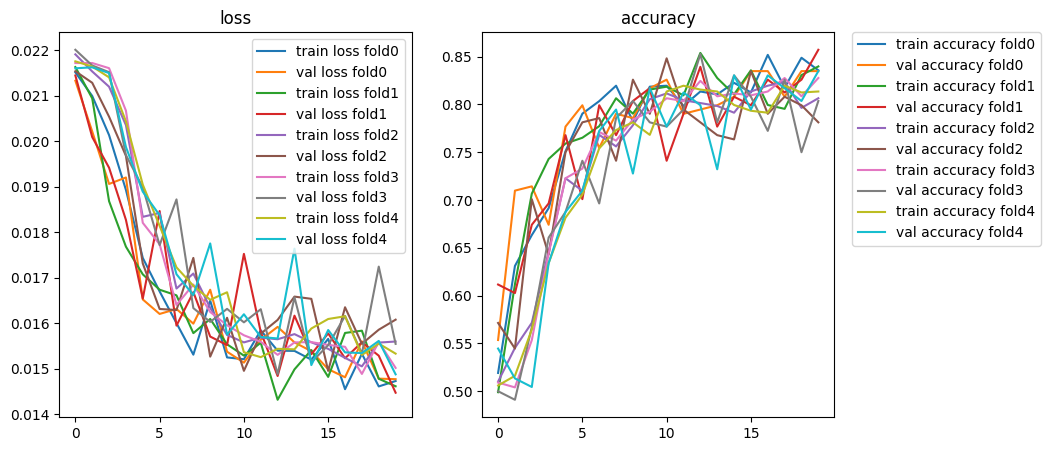

In [303]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].set_title("loss")
ax[1].set_title("accuracy")

for fold, (train_idx, val_idx) in enumerate(skf.split(training_dataset.data[training_dataset.indices], training_dataset.label[training_dataset.indices])):
    print(f"-------------------Fold {fold}-------------------")
    train_dataset = CustomSubset(training_dataset, train_idx)
    val_dataset = CustomSubset(training_dataset, val_idx)

    label_train = [training_dataset.label[i] for i in train_idx]
    class_sample_count = np.array([len(np.where(label_train==t)[0]) for t in np.unique(label_train)])
    weights = 1. / class_sample_count
    samples_weight = torch.from_numpy(np.array([weights[int(t)] for t in label_train]))
    train_sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)

    val_subsampler = SubsetRandomSampler(val_idx)
    val_dataloader = DataLoader(training_dataset, batch_size=batch_size, sampler=val_subsampler, drop_last=True)
    
    model.apply(reset_weights)
    train_losses_history = []
    val_losses_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    pred_history = []
    target_history = []

    for epoch in range(1, epochs+1):
        train_losses, train_correct = train(fold, model, device, train_dataloader, optimizer, epoch, criterion)
        val_losses, val_correct, pred_history, target_history = val(fold, model, device, val_dataloader)
        if val_losses < best_vloss:
            best_vloss = val_losses
            model_path = f"data/project/data/model_{fold}_{epoch}.pt"
            
        train_losses_history.append(train_losses)
        val_losses_history.append(val_losses)
        train_accuracy_history.append(train_correct)
        val_accuracy_history.append(val_correct)

        
    ax[0].plot(train_losses_history, label=f"train loss fold{fold}")
    ax[0].plot(val_losses_history, label=f"val loss fold{fold}")
    ax[1].plot(train_accuracy_history, label=f"train accuracy fold{fold}")
    ax[1].plot(val_accuracy_history, label=f"val accuracy fold{fold}")

ax[0].legend()
ax[1].legend()
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
print(f"Best val loss: {best_vloss:.4f}, model saved to {model_path}")
torch.save(model.state_dict(), model_path)

In [304]:
# pMHC_TCRData.data.shape
# print(len(train_dataset))
# print(len(val_dataset))
# np.array([weights[t] for t in label_train])
# len(val_dataloader)
# [weights[int(t)] for t in label_train]

In [312]:
test_subsampler = SubsetRandomSampler(testing_dataset.indices)
test_dataloader = DataLoader(pMHC_TCRData, batch_size=batch_size, sampler=test_subsampler, drop_last=True)

model = prediction_model(input_size, batch_size).to(device)
model.load_state_dict(torch.load(model_path))

test_loss = 0
correct = 0

fpr_history = []
tpr_history = []
target_history = []
pred_history = []

for data, target in test_dataloader:
    target = target.to(torch.bool).view(-1, 1)
    one_hot_target = torch.zeros((target.shape[0], 2))
    one_hot_target[(target==1).squeeze(), 1] = 1
    one_hot_target[(target==0).squeeze(), 0] = 1
    data, one_hot_target = data.to(device), one_hot_target.to(device)
    data = data.view(-1, input_size).to(torch.float32).data
    output = model(data)
    normalizer = len(test_dataloader) * data.size(0)
    test_loss += criterion(output, one_hot_target.data).item() / normalizer
    pred = output.argmax(dim=1, keepdim=True)
    target = one_hot_target.argmax(dim=1, keepdim=True)
    correct += pred.eq(target).sum().item()
    pred_history.extend(output.cpu().detach().numpy())
    target_history.extend(one_hot_target.cpu().detach().numpy())

auc = roc_auc_score(target_history, pred_history)
print(f"Test set: Average loss: {test_loss:.4f}, \
      Accuracy: {correct}/{normalizer} \
      ({100. * correct / normalizer:.0f}%), AUC: {auc:.4f}")

Test set: Average loss: 0.0139,       Accuracy: 250/288       (87%), AUC: 0.9012


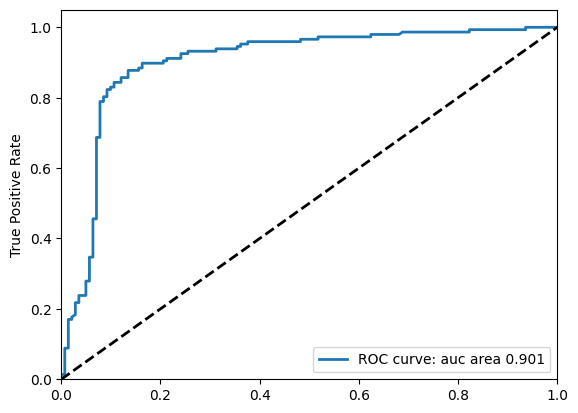

In [318]:
targets = np.zeros((0,2))
for target in target_history:
    targets = np.vstack((targets, target))

preds = np.zeros((0,2))
for pred in pred_history:
    preds = np.vstack((preds, pred))

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}
for i in range(targets.shape[1]):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(list(targets[:, i]), list(preds[:, i]))
    fpr_dict[i] = list(fpr_dict[i])
    tpr_dict[i] = list(tpr_dict[i])

plt.figure()
lw = 2
plt.plot(fpr_dict[0], tpr_dict[0], label=f"ROC curve: auc area {auc:.3f}", lw=lw)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [316]:
len(pMHC_TCRData)

1574

In [320]:
# len(test_dataloader) * data.size(0)
# 247 / 288

For the unified model, which is contempt to the discrete model, the model is trying to model the alpha and beta chain of TCR sequence in one autoencoder. And the result could help to find more information about the TCR sequence.